## Importação dos pacotes

In [1]:
# importar pacotes necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Carga dos dados de entrada

In [2]:
# carregar arquivo de dados de treino
data = pd.read_csv('wine-train.csv', index_col='wine')

# mostrar alguns exemplos de registros
data.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality
wine,,,,,,,,,,,,
2169,7.4,0.19,0.30,12.8,0.053,48.5,229.0,0.99860,3.14,0.49,9.1,good
1382,6.6,0.56,0.16,3.1,0.045,28.0,92.0,0.99400,3.12,0.35,9.1,bad
3346,6.7,0.18,0.24,10.3,0.057,64.0,185.0,0.99519,3.12,0.50,10.6,bad
3308,6.4,0.35,0.28,12.6,0.039,19.0,124.0,0.99539,3.20,0.43,10.6,bad
3167,5.6,0.28,0.40,6.1,0.034,36.0,118.0,0.99144,3.21,0.43,12.1,good


In [4]:
data.shape

(3265, 12)

In [5]:
data.columns.values

array(['fixed_acidity', 'volatile_acidity', 'citric_acid',
       'residual_sugar', 'chlorides', 'free_sulfur_dioxide',
       'total_sulfur_dioxide', 'density', 'ph', 'sulphates', 'alcohol',
       'quality'], dtype=object)

In [10]:
# selecionar colunas a serem usadas na detecção de anomalias
cols = ['fixed_acidity', 'volatile_acidity', 'citric_acid',
       'residual_sugar', 'chlorides', 'free_sulfur_dioxide',
       'total_sulfur_dioxide', 'density', 'ph', 'sulphates']

## Métodos de detecção de outliers

### 1. via gráficos de dispersão

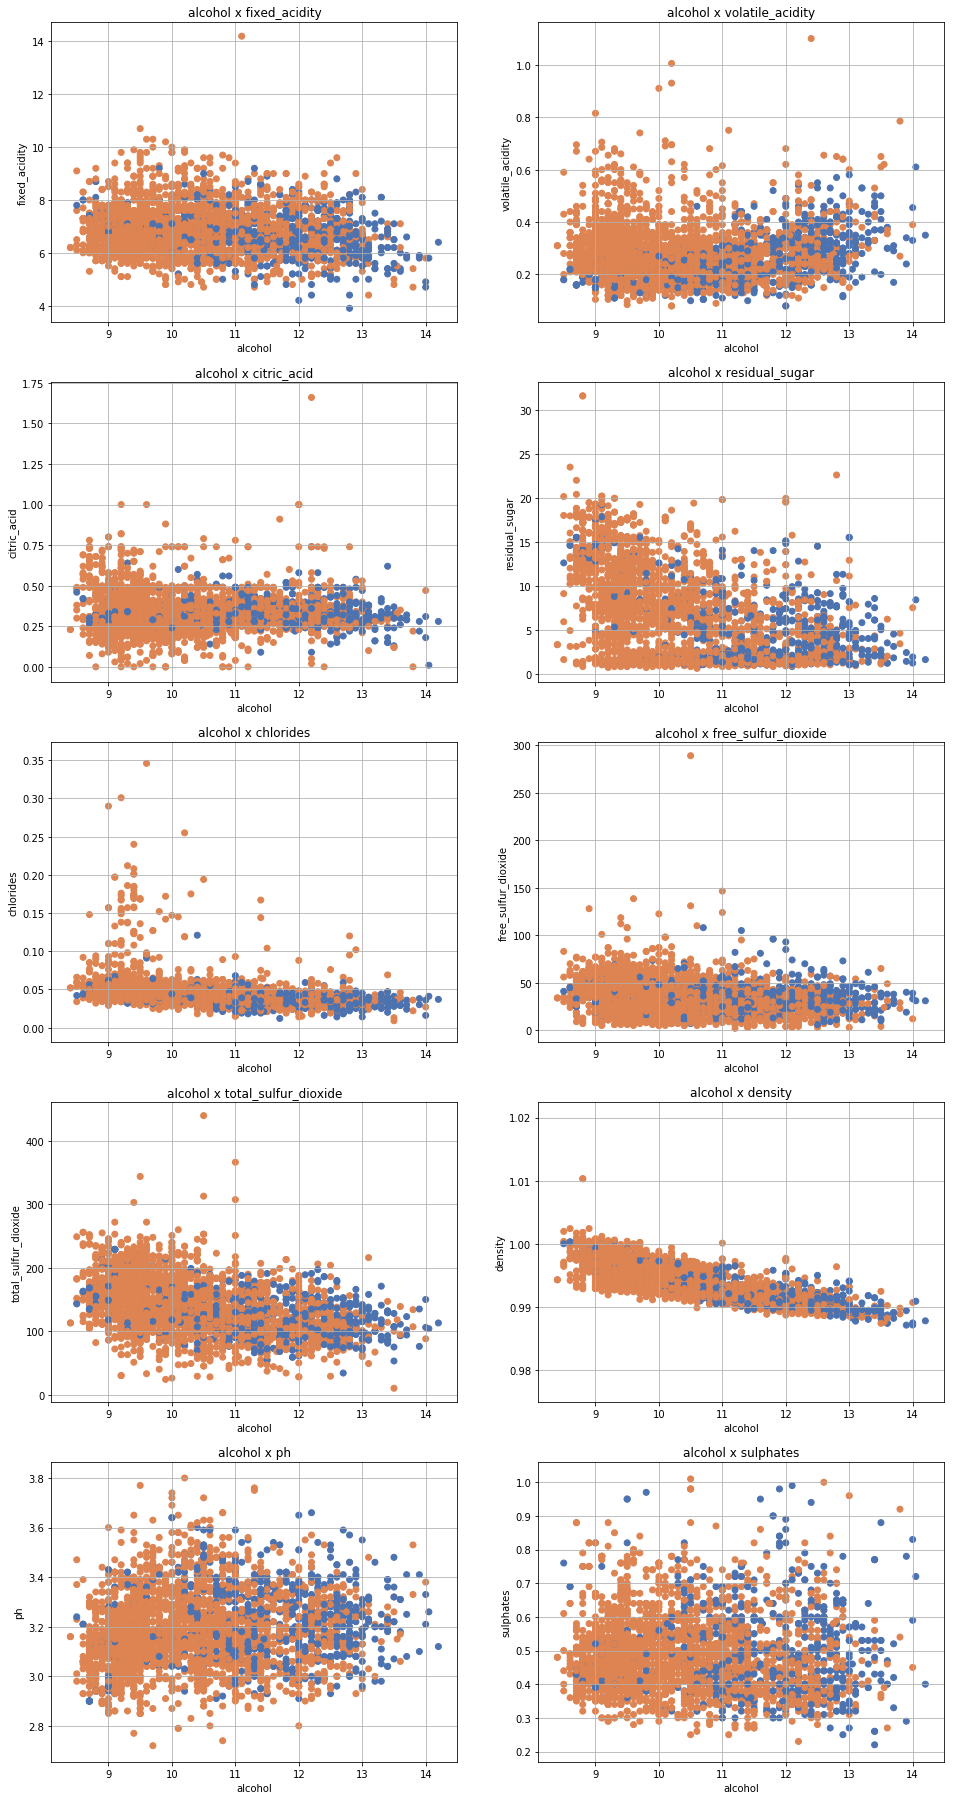

In [17]:
colors = {'good': '#4c72b0', 'bad': '#dd8452'}

# parâmetros
rows_count = 5
cols_count = 2
col_x = 'alcohol'

plt.figure(figsize=(16, 32))

i = 0
for col_y in cols:
    plt.subplot(rows_count, cols_count, (i + 1))
    plt.scatter(data[col_x], data[col_y], c=data['quality'].map(colors))
    #plt.subplots_adjust(hspace=0.4, wspace=0.4)
    plt.xlabel(col_x)
    plt.ylabel(col_y)
    plt.title(col_x + ' x ' + col_y)
    plt.grid()
    i += 1

plt.show()

In [19]:
outliers = np.concatenate((
    data[(data['fixed_acidity'] > 12)].index,
    data[(data['volatile_acidity'] > 0.75)].index,
    data[(data['citric_acid'] > 0.85)].index,
    data[(data['residual_sugar'] > 20)].index,
    data[(data['chlorides'] > 0.25)].index,
    data[(data['free_sulfur_dioxide'] > 150)].index,
    data[(data['total_sulfur_dioxide'] > 300)].index,
    data[(data['density'] > 1.005)].index,
    data[(data['ph'] < 2.8) & (data['ph'] > 3.75)].index,
), axis=0)
print('Número de outliers:', len(outliers))

Número de outliers: 37


In [20]:
# marcar registros com anomalia
data['outlier1'] = data.index.map(lambda idx: 1 if idx in outliers else 0)

In [21]:
print('Número de outliers:', len(data[data.outlier1 == 1].index))

Número de outliers: 34


In [22]:
data.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality,outlier1
wine,,,,,,,,,,,,,
2169,7.4,0.19,0.30,12.8,0.053,48.5,229.0,0.99860,3.14,0.49,9.1,good,0
1382,6.6,0.56,0.16,3.1,0.045,28.0,92.0,0.99400,3.12,0.35,9.1,bad,0
3346,6.7,0.18,0.24,10.3,0.057,64.0,185.0,0.99519,3.12,0.50,10.6,bad,0
3308,6.4,0.35,0.28,12.6,0.039,19.0,124.0,0.99539,3.20,0.43,10.6,bad,0
3167,5.6,0.28,0.40,6.1,0.034,36.0,118.0,0.99144,3.21,0.43,12.1,good,0


In [25]:
data[data.outlier1 == 0].drop(['outlier1'], axis=1).to_csv('wine-train-without-outliers.csv')

### 2. via Z-Score

- https://medium.com/datadriveninvestor/finding-outliers-in-dataset-using-python-efc3fce6ce32

In [9]:
threshold = 3

for col in cols:
#col = 'length'
#if True:
    
    z_col = 'z_' + col
    o_col = 'o_' + col

    col_mean = data[col].mean()
    col_stddev = data[col].std()
    #print('Column:  %s\nMean:    %.2f\nStd Dev: %.4f\n' % (col, col_mean, col_stddev))

    data[z_col] = (data[col] - col_mean) / col_stddev
    data[o_col] = data[z_col].apply(lambda z: 1 if np.abs(z) > threshold else 0)

In [10]:
data['outlier2'] = data['o_length'] + data['o_diameter'] + data['o_height'] + \
                    data['o_whole_weight'] + data['o_shucked_weight'] + \
                    data['o_viscera_weight'] + data['o_shell_weight']

# considerar apenas a variável 'height'
#data['outlier2'] = data['o_height']

# marcar registros com anomalia
data['outlier2'] = data['outlier2'].apply(lambda x: 1 if (x > 0) else 0)

data.outlier2 = data.outlier2.astype('category')

#data[data.outlier2 != 0]

In [11]:
print('Número de outliers:', len(data[data.outlier2 == 1].index))

Número de outliers: 60


### 3. via IQR

- https://medium.com/datadriveninvestor/finding-outliers-in-dataset-using-python-efc3fce6ce32

In [12]:
iqr_factor = 1.5

for col in cols:
#col = 'length'
#if True:

    o_col = 'o_' + col

    col_q1 = data[col].quantile(0.25)
    col_q3 = data[col].quantile(0.75)
    col_iqr = col_q3 - col_q1
    col_lower = col_q1 - (1.5 * col_iqr)
    col_upper = col_q3 + (1.5 * col_iqr)
    
    #print('Column: %s\nQ1:     %.2f\nQ3:     %.4f\nIQR:    %.4f\nLower:  %.4f\nUpper:  %.4f\n' % \
    #      (col, col_q1, col_q3, col_iqr, col_lower, col_upper))

    data[o_col] = data[col].apply(lambda x: 1 if (x < col_lower or x > col_upper) else 0)

In [13]:
data['outlier3'] = data['o_length'] + data['o_diameter'] + data['o_height'] + \
                    data['o_whole_weight'] + data['o_shucked_weight'] + \
                    data['o_viscera_weight'] + data['o_shell_weight']

# considerar apenas a variável 'height'
#data['outlier3'] = data['o_height']

# marcar registros com anomalia
data['outlier3'] = data['outlier3'].apply(lambda x: 1 if (x > 0) else 0)

data.outlier3 = data.outlier3.astype('category')

#data[data.outlier3 != 0]

In [14]:
print('Número de outliers:', len(data[data.outlier3 == 1].index))

Número de outliers: 96


### 4-10. via PyOD

- https://pyod.readthedocs.io/en/latest/
- https://www.analyticsvidhya.com/blog/2019/02/outlier-detection-python-pyod/

In [15]:
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF

In [16]:
outliers_fraction = 0.04 # percentual de "contaminação" (4,0%)
sufixo_arquivo = '%.2f' % (outliers_fraction * 100)

random_state = np.random.RandomState(42)

# modelos a serem usados na detecção de anomalias
classifiers = {
    'Angle-based Outlier Detector (ABOD)': ABOD(contamination=outliers_fraction),
    'Cluster-based Local Outlier Factor (CBLOF)': CBLOF(contamination=outliers_fraction,
                                                        check_estimator=False, random_state=random_state),
    'Feature Bagging': FeatureBagging(LOF(n_neighbors=35), contamination=outliers_fraction,
                       check_estimator=False, random_state=random_state),
    'Histogram-base Outlier Detection (HBOS)': HBOS(contamination=outliers_fraction),
    'Isolation Forest': IForest(contamination=outliers_fraction, random_state=random_state),
    'K Nearest Neighbors (KNN)': KNN(contamination=outliers_fraction),
    'Average KNN': KNN(method='mean', contamination=outliers_fraction)
}

In [17]:
# seleção dos dados a serem usados na detecção automática
X = data[cols]
#X = data[['length', 'height']]
#X = data[['length', 'height', 'whole_weight', 'rings']]
#X.info()

In [18]:
# executar os algoritmos de detecção automática
outlier_start = 4
for i, (clf_name, clf) in enumerate(classifiers.items()):
    print(i + 1, clf)
    clf.fit(X)
    col = 'outlier' + str(i + outlier_start)
    data[col] = clf.labels_
    data[col] = data[col].astype('category')

1 ABOD(contamination=0.04, method='fast', n_neighbors=5)
2 CBLOF(alpha=0.9, beta=5, check_estimator=False, clustering_estimator=None,
   contamination=0.04, n_clusters=8, n_jobs=1,
   random_state=<mtrand.RandomState object at 0xa06c87ac>,
   use_weights=False)
3 FeatureBagging(base_estimator=LOF(algorithm='auto', contamination=0.1, leaf_size=30, metric='minkowski',
  metric_params=None, n_jobs=1, n_neighbors=35, p=2),
        bootstrap_features=False, check_detector=True,
        check_estimator=False, combination='average', contamination=0.04,
        estimator_params={}, max_features=1.0, n_estimators=10, n_jobs=1,
        random_state=<mtrand.RandomState object at 0xa06c87ac>, verbose=0)
4 HBOS(alpha=0.1, contamination=0.04, n_bins=10, tol=0.5)
5 IForest(behaviour='old', bootstrap=False, contamination=0.04,
    max_features=1.0, max_samples='auto', n_estimators=100, n_jobs=1,
    random_state=<mtrand.RandomState object at 0xa06c87ac>, verbose=0)


/opt/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


6 KNN(algorithm='auto', contamination=0.04, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
  radius=1.0)
7 KNN(algorithm='auto', contamination=0.04, leaf_size=30, method='mean',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
  radius=1.0)


### 11. via Diferença de um Modelo Preditivo

In [19]:
X = data[cols]
y = data['rings']

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import OrthogonalMatchingPursuit

#model = LinearRegression(fit_intercept=False, normalize=True)
model = OrthogonalMatchingPursuit(n_nonzero_coefs=7, fit_intercept=False, normalize=True)

model.fit(X, y)

data['predict'] = model.predict(X)
data['diff'] = abs(data.rings - data.predict)

In [21]:
data[['rings', 'predict', 'diff']].describe()

,rings,predict,diff
count,2784.000000,2784.000000,2784.000000
mean,9.936063,9.892032,1.649641
std,3.240543,2.505113,1.541622
min,1.000000,-3.963633,0.000498
25%,8.000000,8.360034,0.587709
50%,10.000000,9.888905,1.232624
75%,11.000000,11.389183,2.202638
max,29.000000,20.301245,13.817957


In [22]:
# definir o limiar para ser considerado anomalia
limiar = data['diff'].mean() + 2.25 * data['diff'].std()

data[['rings', 'predict', 'diff']].head()

,rings,predict,diff
id,,,
2758,10,11.111072,1.111072
1384,9,10.154720,1.154720
1131,8,7.275467,0.724533
3726,8,10.056086,2.056086
3445,8,10.004642,2.004642


In [23]:
# marcar registros com anomalia
data['outlier11'] = data['diff'].apply(lambda x: 1 if (x > limiar) else 0)

In [24]:
print('Número de outliers:', len(data[data['outlier11'] == 1].index))

Número de outliers: 110


## Visualização de gráficos

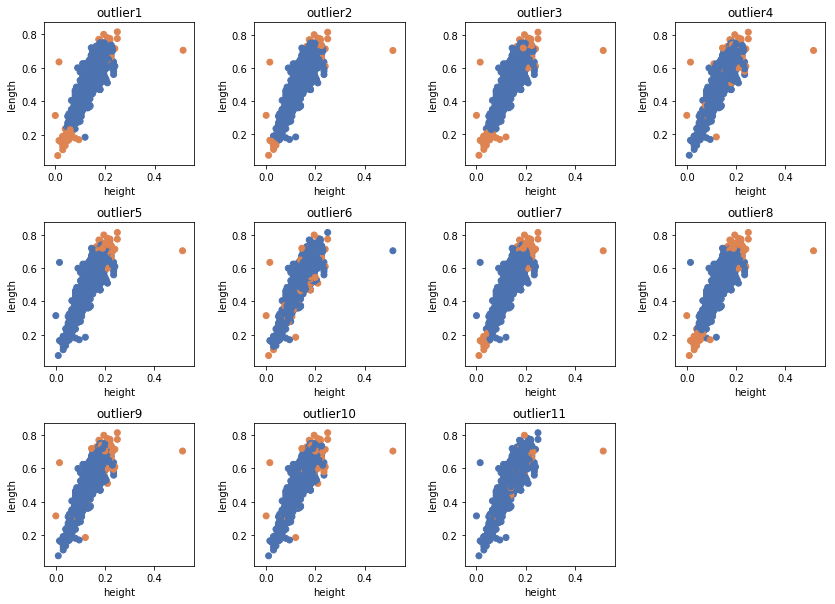

In [25]:
# gerar gráficos de dispersão para cada um dos modelos de outliers

colors = {0: '#4c72b0', 1: '#dd8452'}

# parâmetros
outlier_start = 1
outlier_count = 11
rows_count = 3
cols_count = 4
col_x = 'height'
col_y = 'length'

plt.figure(figsize=(14, 10))

for i in range(outlier_count):
    col = 'outlier' + str(i + outlier_start)
    plt.subplot(rows_count, cols_count, (i + 1))
    plt.scatter(data[col_x], data[col_y], c=data[col].map(colors))
    plt.subplots_adjust(hspace=0.4, wspace=0.4)
    plt.xlabel(col_x)
    plt.ylabel(col_y)
    plt.title(col)

plt.show()

## Geração de arquivos sem as anomalias

In [26]:
!mkdir input/

mkdir: cannot create directory ‘input/’: File exists


In [27]:
# gerar arquivos CSV sem as anomalias
outlier_start = 1
outlier_count = 1 #11

pcols = cols + ['sex', 'rings']
for i in range(outlier_start, outlier_count - outlier_start + 1 + 1):
    col = 'outlier' + str(i)
    filename = 'abalone-train-o' + str(i) + '-' + sufixo_arquivo + '.csv'
    print('Gerando arquivo:', filename)
    data[data[col] == 0][pcols].to_csv('input/' + filename)

Gerando arquivo: abalone-train-o1-4.00.csv


In [28]:
!wc -l  input/abalone-train-o*.csv

    2766 input/abalone-train-o1-0.50.csv
    2766 input/abalone-train-o1-1.00.csv
    2766 input/abalone-train-o1-10.00.csv
    2766 input/abalone-train-o1-15.00.csv
    2697 input/abalone-train-o1-4.00.csv
    2673 input/abalone-train-o1-5.00.csv
    2708 input/abalone-train-o1-6.15.csv
    2673 input/abalone-train-o1-7.50.csv
    2673 input/abalone-train-o1.csv
    2771 input/abalone-train-o10-0.50.csv
    2757 input/abalone-train-o10-1.00.csv
    2506 input/abalone-train-o10-10.00.csv
    2367 input/abalone-train-o10-15.00.csv
    2673 input/abalone-train-o10-4.00.csv
    2645 input/abalone-train-o10-5.00.csv
    2613 input/abalone-train-o10-6.15.csv
    2576 input/abalone-train-o10-7.50.csv
    2764 input/abalone-train-o10.csv
    2675 input/abalone-train-o11-4.00.csv
    2566 input/abalone-train-o11-6.15.csv
    2778 input/abalone-train-o2-0.50.csv
    2778 input/abalone-train-o2-1.00.csv
    2725 input/abalone-train-o2-10.00.csv
    2689 input/abalone-train-o2-15.00.csv
    2725 